In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/workshops/week1'
FOLDERNAME = 'acmlab/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/acmlab/project


In [ ]:
# Importing the standard ML libraries...
%load_ext autoreload
%autoreload 2

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices

import torch
import torchvision                      # for MNIST dataset/working with images

from tqdm.notebook import tqdm

# take advantage of GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<class 'PIL.Image.Image'>


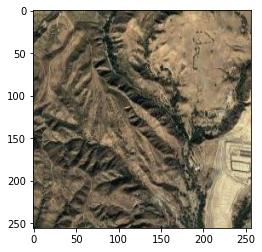

In [ ]:
from PIL import Image
filename = "imagery/14_2794_6528.jpg"
image = Image.open(filename).convert("RGB")
plt.imshow(image)
print(type(image))

In [ ]:
def x(lon, z):
    return 1/360 * 2 ** z * (lon + 180)

def y(lat, z):
    rads = lat * (2*np.pi) / 360
    return 2**z * (np.pi - np.log(np.tan(np.pi/4 + rads/2))) / (2 * np.pi)

def xy(lat, lon, z):
    return x(lon, z), y(lat, z)

def lon(x, z):
    return 360*x/2**z - 180

def lat(y, z):
    rads = 2 * (np.arctan(np.exp(np.pi - 2 * np.pi * y / 2 ** z)) - np.pi/4)
    return 360 * rads / (2 * np.pi)

def latlon(x, y, z):
    return lat(y,z), lon(x,z)

elevfile = 'worldelev.npy'
data = np.load(elevfile, 'r')
resolution = 120 ## points per degree

def getElevation(lat, lon):
    x = int(round((lon + 180) * resolution))
    y = int(round((90 - lat) * resolution)) - 1
    try: return max(0, data[y, x])
    except: return 0

def jpg_to_npy(jpg, npy):
    im = Image.open(jpg)
    array = np.array(im)
    array = np.int16(array)
    np.save(npy, array)

In [ ]:
zipdata = pd.read_csv("ziplatlon.csv", sep=';')
zipdata = zipdata[["zip","latitude","longitude"]]
print(zipdata)
print(zipdata.loc[0])
print(zipdata.loc[0][0])
incdata = pd.read_csv("16zpallnoagi.csv")
incdata = incdata[['ZIPCODE','N1','A02650']]
print(incdata)

         zip   latitude  longitude
0      71937  34.398483  -94.39398
1      72044  35.624351  -92.16056
2      56171  43.660847  -94.74357
3      49430  43.010337  -85.89754
4      52585  41.194129  -91.98027
...      ...        ...        ...
43186  66860  38.126728  -96.16635
43187  59602  46.696501 -111.96895
43188  16063  40.783001  -80.13343
43189  18913  40.376499  -75.04129
43190  25901  37.982775  -81.14533

[43191 rows x 3 columns]
zip          71937.000000
latitude        34.398483
longitude      -94.393980
Name: 0, dtype: float64
71937.0
       ZIPCODE       N1     A02650
0            0  2016530  115806207
1        35004     5210     290260
2        35005     3100     121690
3        35006     1200      57418
4        35007    11940     697882
...        ...      ...        ...
29969    83126      170      10687
29970    83127     1470     109088
29971    83128      920      88463
29972    83414      200      44409
29973    99999     8650     702791

[29974 rows x 3 columns

In [ ]:
print(incdata.loc[incdata['ZIPCODE'] == 90210])
print(len(incdata.loc[incdata['ZIPCODE'] == 90210]))
print(incdata.loc[incdata['ZIPCODE'] == 90421])
print(len(incdata.loc[incdata['ZIPCODE'] == 90421]))

      ZIPCODE    N1   A02650
1704    90210  9490  5827835
1
Empty DataFrame
Columns: [ZIPCODE, N1, A02650]
Index: []
0


In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ToTensor()
        ])
        self.images = []
        for i in tqdm(range(1980)):
            x = i % (2839-2794) + 2794
            y = int(i / (2839-2794)) + 6528
            lat, lon = latlon(x+0.5, y+0.5, 14)
            if getElevation(lat, lon) != 0:
                filename = f"imagery/14_{x}_{y}.jpg"
                image = Image.open(filename).convert("RGB")
                self.images.append({'image':torchvision.transforms.ToTensor()(image), 'zip':0, 'x':x, 'y':y})
                image = self.transform(image)
                self.images.append({'image':image, 'zip':0, 'x':x, 'y':y})
        
        self.zips = {}
        for i in tqdm(range(len(zipdata))):
            zipx, zipy = xy(zipdata.loc[i][1], zipdata.loc[i][2], 14)
            if 2794 <= zipx < 2839 and 6528 <= zipy < 6572 and len(incdata.loc[incdata['ZIPCODE'] == zipdata.loc[i][0]]) == 1:
                for j in range(len(self.images)):
                    if self.images[j]['x']==int(zipx) and self.images[j]['y']==int(zipy):
                        self.images[j]['zip'] = zipdata.loc[i][0]
                        self.zips[zipdata.loc[i][0]] = [zipx, zipy]

        for i in tqdm(range(len(self.images))):
            if self.images[i]['zip'] == 0:
                dist = 10000000
                for zip, loc in self.zips.items():
                    newdist = (self.images[i]['x']-loc[0])**2 + (self.images[i]['y']-loc[1])
                    if newdist < dist:
                        dist = newdist
                        self.images[i]['zip'] = zip
            # if self.images[i]['zip'] in self.zips:
            #     self.zips[self.images[i]['zip']] += 1
            # else:
            #     self.zips[self.images[i]['zip']] = 1
        
        self.incomes = {}
        for zip in self.zips.keys():
            pop = incdata.loc[incdata['ZIPCODE'] == zip,'N1']
            inc = incdata.loc[incdata['ZIPCODE'] == zip,'A02650']
            self.incomes[zip] = inc/pop

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        return self.images[idx]['image'], torch.tensor(self.incomes[self.images[idx]['zip']].values)

In [ ]:
trainset = ImageDataset()

<class 'torch.Tensor'>
<class 'torch.Tensor'> tensor([164.1673], dtype=torch.float64)


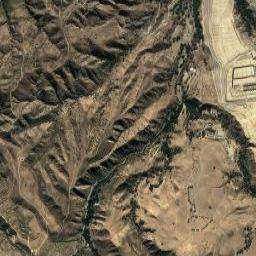

In [ ]:
#for i in range(len(trainset)):
i=1
image, label = trainset[i] # image shape: [3, 256, 256]
print(type(image))
print(type(label), label)
#print(i, len(label))
image = np.moveaxis(np.asarray(image), 0, -1)  # image shape: [256, 256, 3]
image = (image * 255).astype(np.uint8)     # to preview, needs to be ints
display(Image.fromarray(image).convert("RGB"))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
    #self.conv3 = nn.Conv2d(in_channels=10, out_channels=18, kernel_size=3, stride=2, padding=1)
    self.flat = 16*16*16
    self.fc1 = nn.Linear(in_features=self.flat, out_features=12)
    self.fc2 = nn.Linear(in_features=12, out_features=12)
    self.fc3 = nn.Linear(in_features=12, out_features=12)
    self.fc4 = nn.Linear(in_features=12, out_features=12)
    self.out = nn.Linear(in_features=12, out_features=1)
    self.batchnorm = torch.nn.BatchNorm2d(num_features=16)

    self.dropout = torch.nn.Dropout(p=0.5)
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)
    t = self.dropout(t)
    t = self.batchnorm(t)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # t = F.relu(self.conv3(t))
    # t = F.max_pool2d(t, kernel_size=2, stride=2)

    #print(t.shape)

    # fc1
    t = t.view(-1, self.flat)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    t = self.fc3(t)
    t = F.relu(t)

    t = self.fc4(t)
    t = F.relu(t)

    # output
    t = self.out(t)

    return t

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = .3

dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(trainset, batch_size=32, sampler=valid_sampler)

cnn_model = CNNModel().to(device=device)
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.001) 

print(cnn_model)

for epoch in range(100):
    epoch_loss = 0
    cnn_model.train()

    for images, labels in trainloader:
        # Load the images and labels on the GPU
        images = images.to(device=device)
        labels = labels.to(device=device)

        optimizer.zero_grad()                 # resets the information from last time
        pred_labels = cnn_model(images)       # calculates the predictions
        loss = criterion(pred_labels, torch.clamp(labels, 0, 500).to(dtype=torch.float32)) # calculates the loss
        loss.backward()                       # gradient descent, part 1
        torch.nn.utils.clip_grad_norm(cnn_model.parameters(), 20)
        optimizer.step()                      # gradient descent, part 2

        epoch_loss += loss.item() / labels.shape[0]

    print(f"Epoch {epoch}: {epoch_loss}")

    if epoch % 5 == 0:
        cnn_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = cnn_model(images.to(device=device))
                labels = labels.to(device=device)
                total += labels.size(0)
                correct += (abs(outputs-labels)).sum().item()

        print(f'Accuracy of the network on the {total} test images: {correct / total}')
        if correct / total < 94:
            torch.save(cnn_model, "model.pt")
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in trainloader:
                outputs = cnn_model(images.to(device=device))
                labels = labels.to(device=device)
                total += labels.size(0)
                correct += (abs(outputs-labels)).sum().item()

        print(f'Accuracy of the network on the {total} train images: {correct / total}')

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=12, bias=True)
  (fc4): Linear(in_features=12, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
  (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 0: 282.62150706563676
Accuracy of the network on the 876 test images: 116.57232942643928
Accuracy of the network on the 2044 train images: 137.06531941716378
Epoch 1: 173.77058843203955
Epoch 2: 175.07996216842108
Epoch 3: 176.11981884070806
Epoch 4: 175.49959588050842
Epoch 5: 176.3093432358333
Accuracy of the network on the 876 test images: 126.02391841709836
Accuracy of the network on the 2044 train images: 147.79413142730522
Epoch 6: 174.2954419851303
Epoch 7: 174.90572484901972
Epoch 8: 174.86125472613745
Epoch 9: 173.4873594726835
Epoch 10: 171.90854171344213
Accuracy of the network on the 876 test images: 109.84897064528018
Accuracy of the network on the 2044 train images: 118.44062953494218
Epoch 11: 176.48178611482894
Epoch 12: 172.77788049834115
Epoch 13: 171.12244137695856
Epoch 14: 170.53483697346277
Epoch 15: 173.9582110983985
Accuracy of the network on the 876 test images: 108.8013654880534
Accuracy of the network on the 2044 train images: 110.11662815689076
Epoch 1

KeyboardInterrupt: ignored

In [ ]:
cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in testloader:
    outputs = cnn_model(images.to(device=device))
    labels = labels.to(device=device)
    predicted = torch.argmax(outputs.data, dim=1)
    total += labels.size(0)
    correct += (abs(outputs-labels)).sum().item()

print(f'Accuracy of the network on the {total} test images: {correct / total}')

mean = 0
count = 0
for images, labels in trainloader:
    mean += torch.mean(labels)
    count += 1
mean = mean/count
print(mean)

correct = 0
total = 0
with torch.no_grad():
  for images, labels in testloader:
    labels = labels.to(device=device)
    total += labels.size(0)
    correct += (abs(mean-labels)).sum().item()
print(f'Accuracy of the baseline on the {total} test images: {correct / total}')

Accuracy of the network on the 876 test images: 94.57418603744058
tensor(175.5454, dtype=torch.float64)
Accuracy of the baseline on the 876 test images: 98.15454123558906


In [ ]:
#torch.save(cnn_model, "model.pt")

In [ ]:
cnn_model = torch.load("model.pt")
cnn_model.eval()

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=12, bias=True)
  (fc4): Linear(in_features=12, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
  (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [2]:
import torch

cnn_model = torch.load("model.pt")
cnn_model.eval()

def predict(filename):
    image = Image.open(filename).convert("RGB")
    transform = torchvision.transforms.ToTensor()
    image = transform(image)
    image = image.unsqueeze(0)
    outputs = cnn_model(image.to(device=device))
    return outputs.data[0][0]

print(predict("imagery/14_2800_6530.jpg").item())

FileNotFoundError: ignored

In [ ]:
for i in range(len(trainset)):
    image, label = trainset[i]
    labels = labels.to(device=device)
    image = image.to(device=device)
    image = image.unsqueeze(0)
    outputs = cnn_model(image.to(device=device))
    print(f"#{i}: Predicted: {outputs.item()}, Actual: {label.item()}, Difference: {outputs.item()-label.item()}")

#0: Predicted: 164.52484130859375, Actual: 164.16734006734006, Difference: 0.35750124125368643
#1: Predicted: 166.22418212890625, Actual: 164.16734006734006, Difference: 2.0568420615661864
#2: Predicted: 163.14198303222656, Actual: 164.16734006734006, Difference: -1.025357035113501
#3: Predicted: 174.33856201171875, Actual: 164.16734006734006, Difference: 10.171221944378686
#4: Predicted: 165.55068969726562, Actual: 512.4811965811966, Difference: -346.930506883931
#5: Predicted: 176.50843811035156, Actual: 512.4811965811966, Difference: -335.97275847084506
#6: Predicted: 153.2611846923828, Actual: 512.4811965811966, Difference: -359.2200118888138
#7: Predicted: 155.17462158203125, Actual: 512.4811965811966, Difference: -357.3065749991654
#8: Predicted: 152.2144775390625, Actual: 234.048, Difference: -81.8335224609375
#9: Predicted: 172.26316833496094, Actual: 234.048, Difference: -61.784831665039064
#10: Predicted: 174.20741271972656, Actual: 234.048, Difference: -59.84058728027344
#11